In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torch import nn
import  torchvision.transforms as T

In [3]:
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
])

In [4]:
from torchvision.datasets import ImageFolder

In [5]:
data = ImageFolder(root='files/glasses', transform=transform)

In [6]:
batch_size = 16
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
latent_dim = 100

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [9]:
import torch.nn.functional as F

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.linear1 = nn.Linear(31 * 31 * 32, 1024)
        self.linear2 = nn.Linear(1024, latent_dim)
        self.linear3 = nn.Linear(1024, latent_dim)
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std * self.N.sample(mu.shape)
        return mu, std, z


In [11]:
class Decoder(nn.Module):
    def __init__(self, laten_dim=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 31 * 31 * 32),
            nn.ReLU(inplace=True),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 31, 31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return torch.sigmoid(x)

In [12]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z)

In [13]:
vae = VAE().to(device)

In [14]:
lr = 1e-4

In [15]:
optimizer = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

In [16]:
from tqdm import tqdm
def train_epoch(epoch):
    vae.train()
    epoch_loss = 0
    loop = tqdm(loader, leave=False)
    for imgs, _ in loop:
        imgs = imgs.to(device)
        mu, std, out = vae(imgs)
        reconstruction_loss = ((out - imgs) ** 2).sum()
        kl = ((std**2)/2 + (mu**2)/2 - torch.log(std) - 0.5).sum()
        loss = reconstruction_loss + kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        loop.set_postfix(epoch=epoch, loss=loss.item())

In [17]:
import torchvision
def plot_epoch():
    with torch.no_grad():
        noise = torch.randn(18, latent_dim).to(device)
        imgs = vae.decoder(noise).cpu()
        imgs = torchvision.utils.make_grid(imgs, 6, 3).numpy()
        plt.imshow(imgs.transpose(1, 2, 0))
        plt.axis('off')
        plt.show()

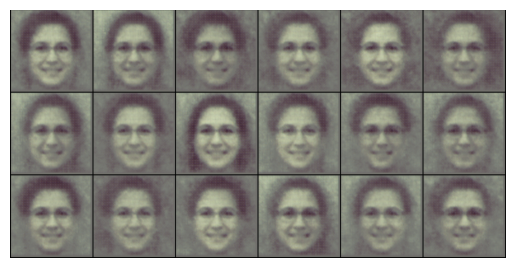

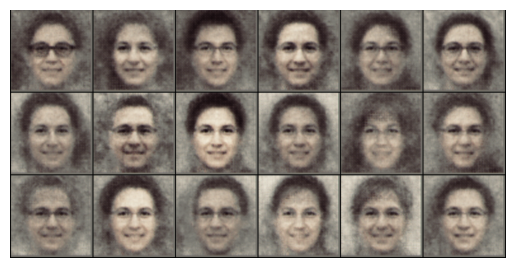

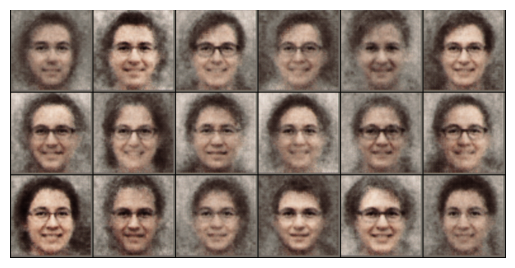

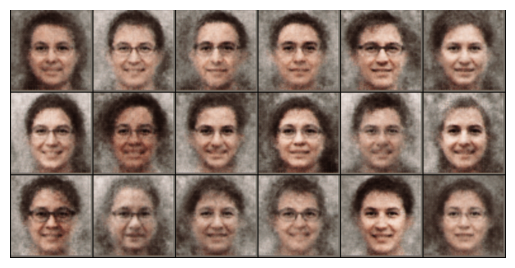

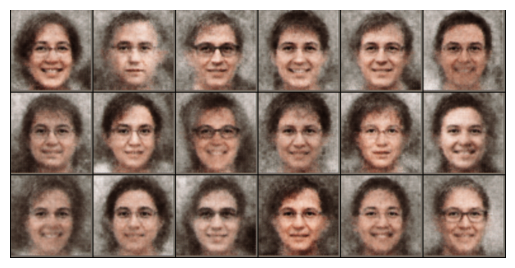

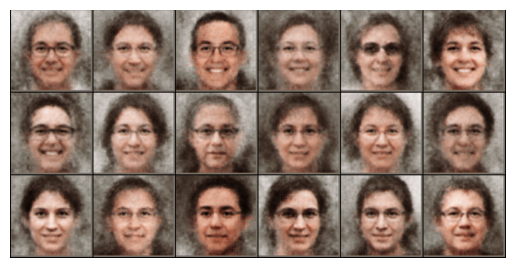

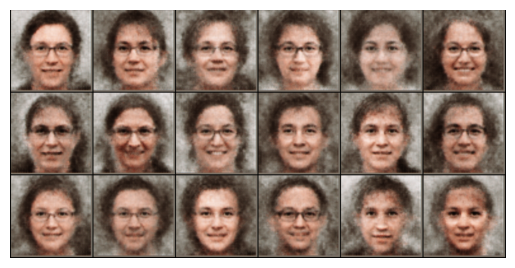

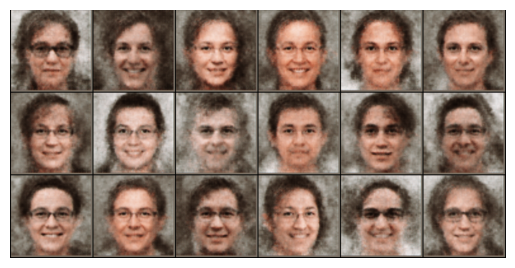

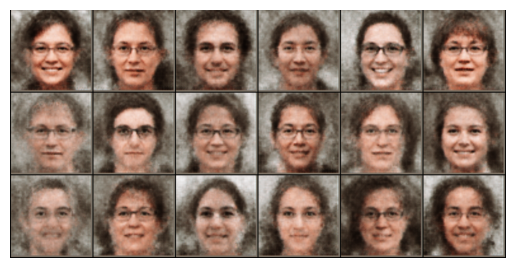

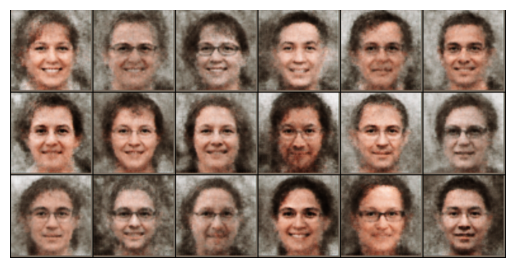

In [18]:
for epoch in range(10):
    train_epoch(epoch)
    plot_epoch()

In [19]:
torch.save(vae.state_dict(), 'files/models/vae.pth')

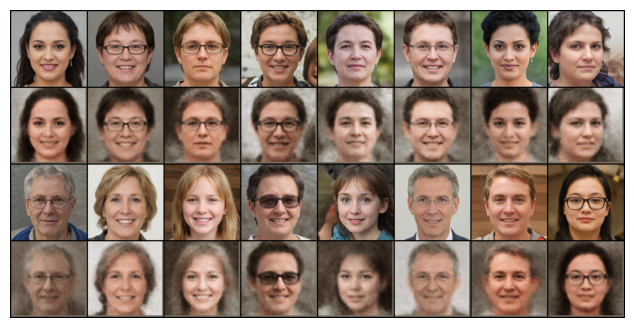

In [20]:
imgs,_=next(iter(loader))
imgs = imgs.to(device)
mu, std, out = vae(imgs)
images=torch.cat([imgs[:8],out[:8],imgs[8:16],out[8:16]],
dim=0).detach().cpu()
images = torchvision.utils.make_grid(images,8,4)
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis("off")
plt.show()

In [21]:
men_g = [525, 527, 529]
women_g = [526, 530, 536]

In [22]:
women_ng = [863, 918, 1182]

In [23]:
men_ng = [716, 774, 1211]

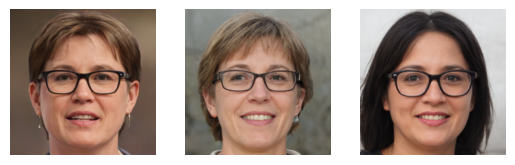

In [24]:
for i, img_index in enumerate(women_g):
    img, label = data[img_index]
    plt.subplot(1, 3,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()

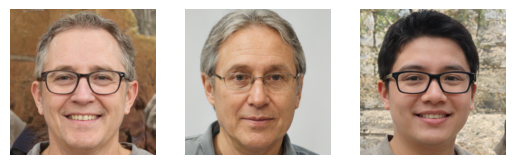

In [25]:
for i, img_index in enumerate(men_g):
    img, label = data[img_index]
    plt.subplot(1, 3,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()

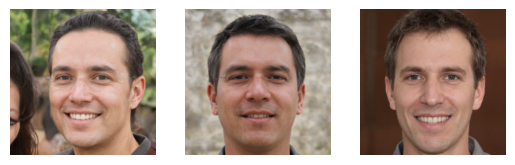

In [26]:
for i, img_index in enumerate(men_ng):
    img, label = data[img_index]
    plt.subplot(1, 3,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()

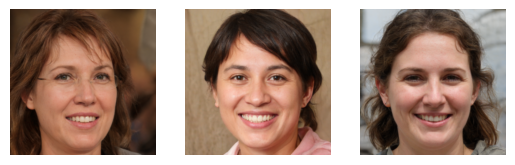

In [27]:
for i, img_index in enumerate(women_ng):
    img, label = data[img_index]
    plt.subplot(1, 3,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()

In [28]:
men_g = [data[i][0] for i in men_g]
men_ng = [data[i][0] for i in men_ng]
women_g = [data[i][0] for i in women_g]
women_ng = [data[i][0] for i in women_ng]


In [30]:
# create a batch of images of men with glasses
men_g_batch = torch.cat((men_g[0].unsqueeze(0),
men_g[1].unsqueeze(0),
men_g[2].unsqueeze(0)), dim=0).to(device)
# Obtain the three encodings
_,_,men_g_encodings=vae.encoder(men_g_batch)
# Average over the three images to obtain the encoding for the group
men_g_encoding=men_g_encodings.mean(dim=0)
# Decode the average encoding to create an image of a man with glasses
men_g_recon=vae.decoder(men_g_encoding.unsqueeze(0))
# Do the same for the other three groups
# group 2, women with glasses
women_g_batch = torch.cat((women_g[0].unsqueeze(0),
women_g[1].unsqueeze(0),
women_g[2].unsqueeze(0)), dim=0).to(device)
# group 3, men without glasses
men_ng_batch = torch.cat((men_ng[0].unsqueeze(0),
men_ng[1].unsqueeze(0),
men_ng[2].unsqueeze(0)), dim=0).to(device)
# group 4, women without glasses
women_ng_batch = torch.cat((women_ng[0].unsqueeze(0),
women_ng[1].unsqueeze(0),
women_ng[2].unsqueeze(0)), dim=0).to(device)
# obtain average encoding for each group
_,_,women_g_encodings=vae.encoder(women_g_batch)
women_g_encoding=women_g_encodings.mean(dim=0)
_,_,men_ng_encodings=vae.encoder(men_ng_batch)
men_ng_encoding=men_ng_encodings.mean(dim=0)
_,_,women_ng_encodings=vae.encoder(women_ng_batch)
women_ng_encoding=women_ng_encodings.mean(dim=0)
# decode for each group
women_g_recon=vae.decoder(women_g_encoding.unsqueeze(0))
men_ng_recon=vae.decoder(men_ng_encoding.unsqueeze(0))
women_ng_recon=vae.decoder(women_ng_encoding.unsqueeze(0))

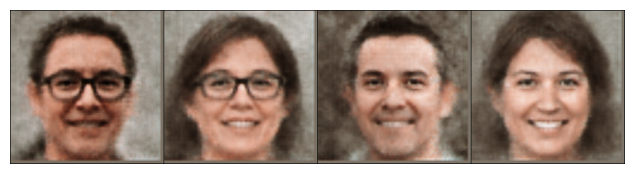

In [31]:
imgs=torch.cat((men_g_recon,
women_g_recon,
men_ng_recon,
women_ng_recon),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

In [32]:
z=men_g_encoding-women_g_encoding+women_ng_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_g_recon, women_g_recon, women_ng_recon,out),dim=0)

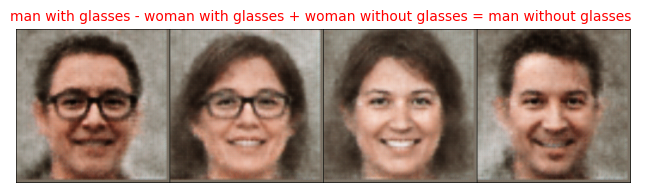

In [33]:
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("man with glasses - woman \
with glasses + woman without \
glasses = man without glasses ",fontsize=10,c="r")
plt.axis("off")
plt.show()

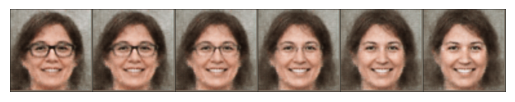

In [34]:
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*women_ng_encoding+(1-w)*women_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()